In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style='whitegrid')

DATA_DIR = Path('../data/raw')

orders = pd.read_csv(DATA_DIR / 'orders.csv', parse_dates=['created_at'])
order_items = pd.read_csv(DATA_DIR / 'order_items.csv')
products = pd.read_csv(DATA_DIR / 'products.csv')
categories = pd.read_csv(DATA_DIR / 'categories.csv')

In [9]:
completed = orders[orders['status'] == 'completed'].copy()
completed['month'] = completed['created_at'].dt.to_period('M')

items = order_items.merge(
    products[['id', 'category_id']].rename(columns={'id': 'product_id_ref'}),
    left_on='product_id', right_on='product_id_ref'
).drop(columns='product_id_ref')

items = items.merge(
    categories.rename(columns={'id': 'category_id_ref', 'name': 'category_name'}),
    left_on='category_id', right_on='category_id_ref'
).drop(columns='category_id_ref')

items = items.merge(
    completed[['id', 'month']].rename(columns={'id': 'order_id_ref'}),
    left_on='order_id', right_on='order_id_ref'
).drop(columns='order_id_ref')

category_monthly = items.groupby(['month', 'category_name']).agg(
    units_sold=('quantity', 'sum'),
    revenue=('unit_price', lambda x: (x * items.loc[x.index, 'quantity']).sum())
).reset_index()

category_monthly['month_str'] = category_monthly['month'].astype(str)
category_monthly.head()

,month,category_name,units_sold,revenue,month_str
0,2024-02,Automotive,13,1952.14,2024-02
1,2024-02,Beauty & Health,18,3506.71,2024-02
2,2024-02,Books,11,2690.63,2024-02
3,2024-02,Clothing,10,3690.76,2024-02
4,2024-02,Electronics,18,4188.58,2024-02


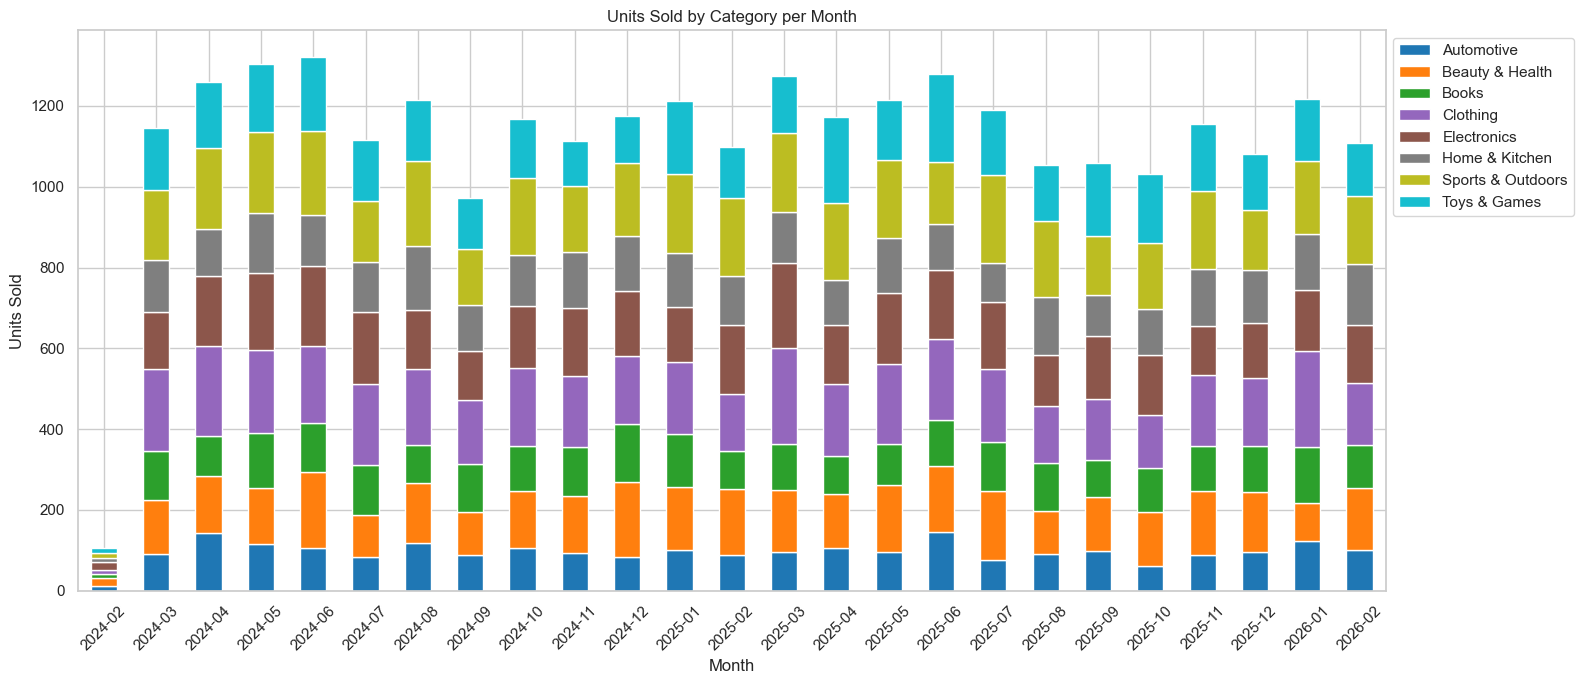

In [10]:
pivot = category_monthly.pivot_table(index='month_str', columns='category_name', values='units_sold', fill_value=0)

fig, ax = plt.subplots(figsize=(16, 7))
pivot.plot(kind='bar', stacked=True, ax=ax, colormap='tab10')
ax.set_title('Units Sold by Category per Month')
ax.set_ylabel('Units Sold')
ax.set_xlabel('Month')
ax.tick_params(axis='x', rotation=45)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('../data/processed/units_by_category.png', dpi=150)
plt.show()

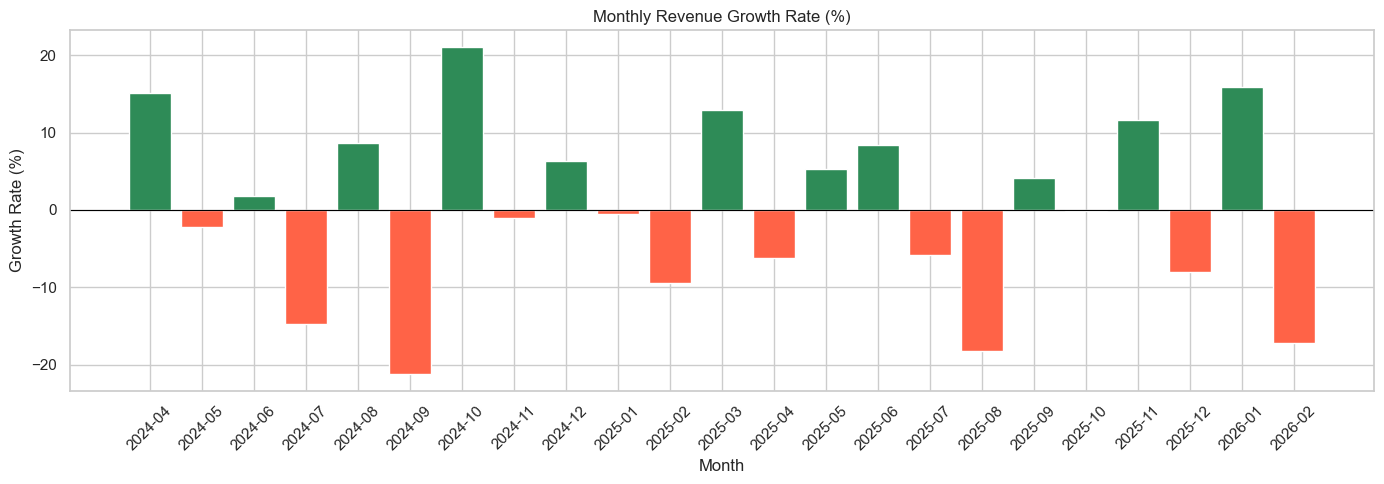

In [11]:
monthly_revenue = completed.groupby('month')['total_amount'].sum().reset_index()
monthly_revenue.columns = ['month', 'revenue']
monthly_revenue['prev_revenue'] = monthly_revenue['revenue'].shift(1)
monthly_revenue['growth_rate_pct'] = ((monthly_revenue['revenue'] - monthly_revenue['prev_revenue']) / monthly_revenue['prev_revenue'] * 100).round(2)
monthly_revenue['month_str'] = monthly_revenue['month'].astype(str)

plot_data = monthly_revenue.dropna(subset=['growth_rate_pct']).iloc[1:]

fig, ax = plt.subplots(figsize=(14, 5))
colors = ['seagreen' if x >= 0 else 'tomato' for x in plot_data['growth_rate_pct']]
ax.bar(plot_data['month_str'], plot_data['growth_rate_pct'], color=colors)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Monthly Revenue Growth Rate (%)')
ax.set_ylabel('Growth Rate (%)')
ax.set_xlabel('Month')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.savefig('../data/processed/revenue_growth.png', dpi=150)
plt.show()

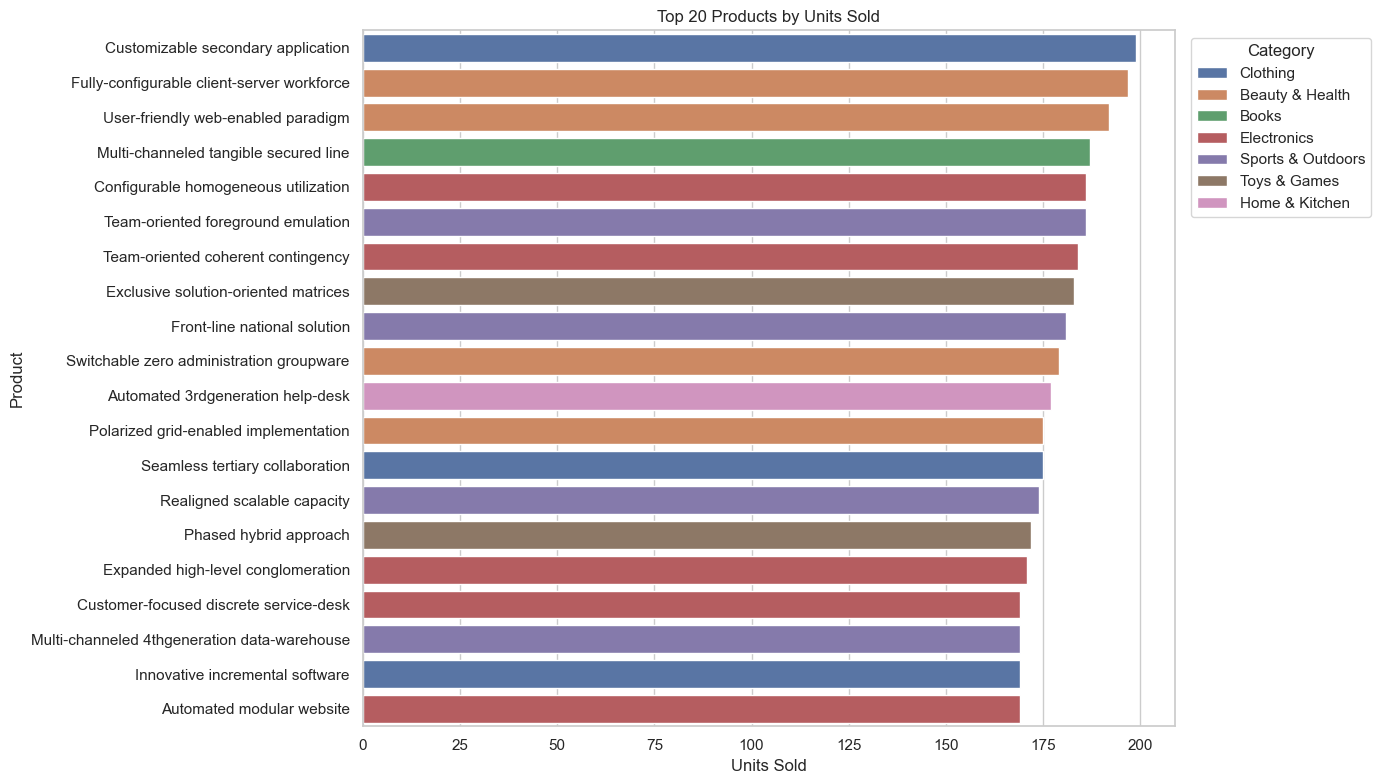

In [12]:
items_full = order_items.merge(
    products[['id', 'name', 'category_id']].rename(columns={'id': 'product_id_ref', 'name': 'product_name'}),
    left_on='product_id', right_on='product_id_ref'
).drop(columns='product_id_ref')

items_full = items_full.merge(
    categories.rename(columns={'id': 'category_id_ref', 'name': 'category_name'}),
    left_on='category_id', right_on='category_id_ref'
).drop(columns='category_id_ref')

items_full = items_full.merge(
    completed[['id', 'user_id']].rename(columns={'id': 'order_id_ref'}),
    left_on='order_id', right_on='order_id_ref'
).drop(columns='order_id_ref')

top_products = items_full.groupby(['product_name', 'category_name']).agg(
    total_units=('quantity', 'sum'),
    total_revenue=('unit_price', lambda x: (x * items_full.loc[x.index, 'quantity']).sum()),
    unique_buyers=('user_id', 'nunique')
).reset_index().sort_values('total_units', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(14, 8))
sns.barplot(data=top_products, y='product_name', x='total_units', hue='category_name', dodge=False, ax=ax)
ax.set_title('Top 20 Products by Units Sold')
ax.set_xlabel('Units Sold')
ax.set_ylabel('Product')
ax.legend(title='Category', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../data/processed/top_products.png', dpi=150, bbox_inches='tight')
plt.show()